In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import omni_normtest

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import scale, minmax_scale, robust_scale
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from statsmodels.tools.eval_measures import rmse

%matplotlib inline
sns.set(font="AppleGothic")
plt.rcParams['axes.unicode_minus']=False

from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import os
os.environ['PATH']+=os.pathsep+'/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/graphviz'

# 콘크리트 강도 예측
## Decision Tree 방법 적용

In [2]:
df = pd.read_csv('Concrete.csv', engine='python', encoding='cp949')
df.head(n=3)

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27


### test 데이터 40%로 약 400개이다.

In [4]:
df_raw_y = df['strength']
df_raw_x = df.drop('strength', axis=1, inplace=False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.4, random_state=1234)

print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data Y size: {}'.format(df_test_y.shape))

train data X size: (618, 8)
train data Y size: (618,)
test data X size: (412, 8)
test data Y size: (412,)


# 1. 모델 생성
## score해석
모델의 설명력은 train 100%, test 79%로 모델이 train 데이터에 과대적합 되어있다.

In [16]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print('Tree_uncustomized Score on training set: {:3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Tree_uncustomized Score on test set: {:3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Tree_uncustomized Score on training set: 0.996010
Tree_uncustomized Score on test set: 0.789790


# 1-1. 모델 파라메터 조정: 잎사귀 노드의 최소 자료 수
### 해석
잎사귀 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소하므로, train과 test 데이터의 성능 차이가 작은 5, 9, 12에 대해 모델 비교하기로 결정


In [37]:
train_score, test_score = [], []
min_leaf= [n_leaf for n_leaf in range(1,20)] # 잎사귀 최소 자료 수

for v_min_samples in min_leaf:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSampleLeaf'] = min_leaf 
df_score_leaf['TrainScore'] = train_score 
df_score_leaf['TestScore'] = test_score
df_score_leaf.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


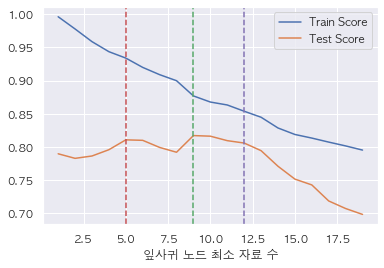

In [32]:
plt.plot(min_leaf, train_score, linestyle='-', label = 'Train Score')
plt.plot(min_leaf, test_score, linestyle='-', label = 'Test Score')
plt.axvline(x = 5, color = 'r', linestyle = '--')
plt.axvline(x = 9, color = 'g', linestyle = '--')
plt.axvline(x = 12, color = 'm', linestyle = '--')
plt.xlabel('잎사귀 노드 최소 자료 수')
plt.legend()

# 잎사귀 노드 최소 자료 수: 5개, 8개, 12개인 모델과 비교
### 해석
- 잎사귀 노드 최소 자료수가 증가할수록 노드 개수가 감소한다.
- 잎사귀 노드 최소 자료 수: 5개, 8개, 12개인 모델 모두 왼쪽과 오른쪽 노드의 수가 **불균형** 하다.

### 선택=>train 데이터의 성능이 높은 5 선택

In [33]:
feature_name = df_train_x.columns

test_min_sample_leaf = [5,9,12]
for minnum in test_min_sample_leaf:
    tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=minnum)
    tree_graph.fit(df_train_x, df_train_y)
    export_graphviz(tree_graph, out_file='tree_leaf.dot', feature_names=feature_name, impurity=True, filled=True)

    with open('tree_leaf.dot') as f:
        dot_graph = f.read()

    g = graphviz.Source(dot_graph)
    g.format='png'
    g.render(filename='tree_'+str(minnum)) #tree_n.png 저장
#     display(g)

# 잎사귀 노드 최소 자료 수: 5개 모델
![](tree_5.png)
# 잎사귀 노드 최소 자료 수: 9개 모델
![](tree_9.png)
# 잎사귀 노드 최소 자료 수: 12개 모델
![](tree_12.png)

# 1-2. 모델 파라메터 조정: 분리 노드의 최소 자료 수
### 해석
train_score, test_score 의 차이가 작은 12, 24 선택하여 비교하기로 결정

In [54]:
train_score, test_score = [], []
min_split= [n_split*2 for n_split in range(2,20)] # 분리 노드의 최소 자료 수

for v_min_samples in min_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=5, min_samples_split=v_min_samples)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSampleSplit'] = min_leaf 
df_score_leaf['TrainScore'] = train_score 
df_score_leaf['TestScore'] = test_score
df_score_leaf.round(3)

,MinSampleSplit,TrainScore,TestScore
0,4,0.934,0.811
1,6,0.934,0.811
2,8,0.934,0.811
3,10,0.934,0.811
4,12,0.926,0.822
5,14,0.919,0.815
6,16,0.915,0.794
7,18,0.898,0.794
8,20,0.894,0.798
9,22,0.886,0.798


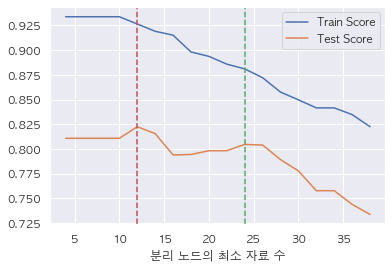

In [51]:
plt.plot(min_split, train_score, linestyle='-', label = 'Train Score')
plt.plot(min_split, test_score, linestyle='-', label = 'Test Score')
plt.axvline(x = 12, color = 'r', linestyle = '--')
plt.axvline(x = 24, color = 'g', linestyle = '--')
plt.xlabel('분리 노드의 최소 자료 수')
plt.legend()

In [52]:
test_min_sample_leaf = [12, 24]
for minnum in test_min_sample_leaf:
    tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=5, min_samples_split=minnum)
    tree_graph.fit(df_train_x, df_train_y)
    export_graphviz(tree_graph, out_file='tree_leaf.dot', feature_names=feature_name, impurity=True, filled=True)

    with open('tree_leaf.dot') as f:
        dot_graph = f.read()

    g = graphviz.Source(dot_graph)
    g.format='png'
    g.render(filename='tree_5_'+str(minnum)) #tree_5_n.png 저장
#     display(g)

# 분리 노드의 최소 자료 수: 12개, 24개인 모델과 비교
### 해석
- 분리 노드의 최소 자료 수가 증가할수록 노드 개수가 감소한다.
- 분리 노드의 최소 자료 수: 12개, 24개인 모델 모두 왼쪽과 오른쪽 노드의 수가 **불균형** 하다.

### 선택=>train 데이터의 성능이 높은 12 선택

# 분리 노드의 최소 자료 수: 12개 모델
![](tree_5_12.png)
# 분리 노드의 최소 자료 수: 24개 모델
![](tree_5_24.png)

# 1-3. 모델 파라메터 조정: 최대 깊이
## 선택=>6
이유: train_score, test_score 가 0.912	0.815으로 높으므로 선택.

In [55]:
train_score, test_score = [], []
para_depth= [i for i in range(1,11)] # 분리 노드의 최소 자료 수

for v_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=5, min_samples_split=12, max_depth=v_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

df_score_depth = pd.DataFrame()
df_score_depth['Maxdepth'] = para_depth
df_score_depth['TrainScore'] = train_score 
df_score_depth['TestScore'] = test_score
df_score_depth.round(3)

,Maxdepth,TrainScore,TestScore
0,1,0.249,0.243
1,2,0.474,0.406
2,3,0.644,0.567
3,4,0.749,0.671
4,5,0.832,0.734
5,6,0.881,0.794
6,7,0.912,0.815
7,8,0.920,0.815
8,9,0.925,0.812
9,10,0.926,0.812


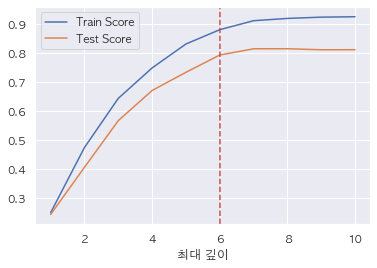

In [59]:
plt.plot(para_depth, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle='-', label = 'Test Score')
plt.axvline(x = 6, color = 'r', linestyle = '--')
plt.xlabel('최대 깊이')
plt.legend()

In [63]:
feature_name = df_train_x.columns

test_depth = [6]
for minmum in test_depth:
    tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=5, min_samples_split=12, max_depth=minmum)
    tree_graph.fit(df_train_x, df_train_y)
    export_graphviz(tree_graph, out_file='tree_leaf.dot', feature_names=feature_name, impurity=True, filled=True)

    with open('tree_leaf.dot') as f:
        dot_graph = f.read()

    g = graphviz.Source(dot_graph)
    g.format='png'
    g.render(filename='tree_5_12_'+str(minnum)) #tree_5_12_n.png 저장
#     display(g)

# 최대 깊이: 6인 모델
### 해석

잎사귀 노드 최소 자료 수, 분리 노드의 최소 자료 수 파라메터만 설정하고 최대 깊이를 설정하지 않았던 모델보다

최대 깊이 설정 후 결과가 더 균형 잡힌 것이 확인됩니다.


![](tree_5_12_6.png)

# 3.최종 모델
## 파라메터: 잎사귀 노드 최소 자료 수=5, 분리 노드의 최소 자료 수=12, 최대 깊이=6

## 해석
- 트리 분리에 영향이 큰 변수 3가지는 순서대로 age(연식), cement(시멘트 종류), water(물 함량)입니다.

- 굵은 입자 콘크리트 재료의 중요도 값은 0으로 나왔지만, 선택된 데이터에 따라 중요도가 변경될 수 있습니다.

- 콘크리트 연식이 21년 이하이고 cement 종류가 354.5이하이면, 콘크리트 강도 평균이 35.4->23.0으로 감소+MSE 감소

- 콘크리트 연식이 21년 초과이고, 물 함량이 175.55이하이면 콘크리트 강도 평균이 35.4->41.2으로 증가+MSE 감소
	

## 최종 해석
📌콘크리트는 연식이 높아지고 생성 당시 물 함량이 낮을 수록 강도가 높으며, 시멘트 종류에 따라 영향을 받는 것으로 해석됩니다.

![](tree_5_12_6.png)

In [74]:
df_importance = pd.DataFrame()
df_importance['Feature'] = feature_name
df_importance['Importance'] = tree_final.feature_importances_
df_importance.sort_values('Importance', ascending=True, inplace=True)
df_importance.round(3)


,Feature,Importance
5,coarse_aggregate,0.000
6,fine_aggregate,0.029
1,blast_furnace_slag,0.040
4,superplasticizer,0.050
2,fly_ash,0.053
3,water,0.213
0,cement,0.250
7,age,0.366


Text(0, 0.5, '변수')

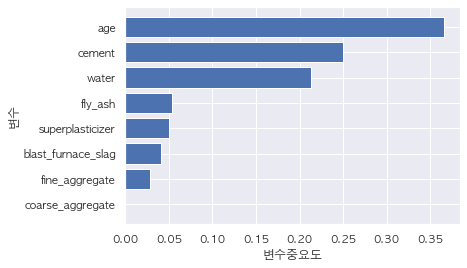

In [75]:
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수중요도')
plt.ylabel('변수')

# 4.GridSearchCV: 모델 parameter 자동 조정
## 파라메터: min_samples_leaf=4,min_samples_split=8, max_depth=10

파라메터를 하나씩 분석하여 지정해주었을 때 결과 (지잎사귀 노드 최소 자료 수=5, 분리 노드의 최소 자료 수=12, 최대 깊이=6)와 다르다.

## score: 0.789
GridSearchCV로 찾아낸 파라메터 세트로 의사결정 트리 분석을 하면 콘크리트 강도 설명력이 78.9%이다.

In [77]:
estimator = DecisionTreeRegressor()
param_grid = {'criterion':['mse', 'friedman_mse','mae'], 'max_features':['auto', 'sqrt', 'log2'], 'max_depth': para_depth, 
             'min_samples_split':min_split, 'min_samples_leaf':min_leaf}
grid_dt = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [4, 6, 8, 10, 12, 14, 16, 18, 20,
                                              22, 24, 26, 28, 30, 32, 34, 36,
                                              38],
                         'min_samples_split': [4, 6, 8, 10, 12, 14, 16, 18, 20,
                                               22, 24, 26, 28, 30, 32, 34, 36,
                                               38]},
             scoring='r2')

In [87]:

print('best estimator model:\n',grid_dt.best_estimator_)
print('\nbest parameter:\n',grid_dt.best_params_)
print('\nbest score:\n',grid_dt.best_score_.round(3))

best estimator model:
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      max_features='auto', min_samples_leaf=4,
                      min_samples_split=8)

best parameter:
 {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 8}

best score:
 0.789
